### Установка необходимых библиотек

In [ ]:
!sudo apt update
!sudo apt install libgeos++-dev libgeos-3.8.0 libgeos-c1v5 libgeos-dev libgeos-doc
!sudo apt install proj-bin libproj-dev
!pip install shapely
!pip install pyshp
!pip install pyproj
!pip install cartopy
!pip install aacgmv2
!pip install opencv-python
!pip install lsq-ellipse
!pip install geopy

### Подключение необходимых библиотек

In [1]:
import os
import sys
import cv2
import h5py
import time
import os.path
import aacgmv2
import glob as gl
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from argparse import ArgumentParser
from sklearn.cluster import KMeans
from scipy.optimize import curve_fit
from scipy.interpolate import griddata
from ellipse import LsqEllipse
import geopy.distance
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import radians, cos, sin, asin, sqrt

### Вспомогательные функции

In [ ]:
IONOSPHERIC_HEIGHT = 300
PARAM_FILE_PATH = 'parameters.csv'
L = 13


def kmeans(X):
    model = KMeans(n_clusters=2).fit(X.reshape(-1, 1))
    threshold = (model.cluster_centers_[0][0]+model.cluster_centers_[1][0])/2
    
    return threshold


def otsu(X):
    weight = 1.0/len(X)
    y, x = np.histogram(X)

    x = x[:-1]

    threshold = -1000
    max_value = -1

    for i in range(1,len(x)-1):
        pcb = np.sum(y[:i])
        pcf = np.sum(y[i:])
        Wb = pcb * weight
        Wf = pcf * weight
        mub = np.sum(x[:i]*y[:i]) / float(pcb)
        muf = np.sum(x[i:]*y[i:]) / float(pcf)
        value = Wb * Wf * (mub - muf)**2

        if value > max_value:
            threshold = x[i]
            max_value = value

    return threshold


def median(X):
    threshold = np.median(X)
    
    return threshold


def quantile(X, level):
    X_min = X.min()
    X_max = X.max()

    bins = 20
    width = (X_max - X_min) / bins

    y, x = np.histogram(X, range=(X_min, X_max), bins=bins, density=True)

    summa = 0
    for i in range(len(y)):
        summa += y[i]*width
        if summa > level:
            return x[i]

    return 0


def binarize(X, threshold):
    Y = np.zeros(X.shape)
    Y[X >= threshold] = 1

    return Y


def make_ellipse_points(center, width, height, phi):
    t = np.linspace(0, 2*np.pi, 1000)
    ellipse_x = center[0] + width*np.cos(t)*np.cos(phi) - height*np.sin(t)*np.sin(phi)
    ellipse_y = center[1] + width*np.cos(t)*np.sin(phi) + height*np.sin(t)*np.cos(phi)

    ellipse_x = np.append(ellipse_x, ellipse_x[0])
    ellipse_y = np.append(ellipse_y, ellipse_y[0])

    return ellipse_x, ellipse_y


def to_lat_lon(x, y, projection):
    lon_lat = ccrs.Geodetic().transform_point(x, y, projection)
    return lon_lat[1], lon_lat[0]


def get_border_points(lats, lons, rotis, threshold, border_type='outer'):
    lons_lats = list(zip(lons, lats))

    # шаг сетки
    rRes = 0.1
    lons_range = np.arange(np.nanmin(lons), np.nanmax(lons)+rRes, rRes)
    lats_range = np.arange(np.nanmin(lats), np.nanmax(lats)+rRes, rRes)

    lons_matrix, lats_matrix = np.meshgrid(lons_range, lats_range)

    # интерполяция значений из точек в узлы сетки
    rotis_matrix = griddata(lons_lats, rotis, (lons_matrix, lats_matrix), method='linear')

    # обогащение данных ROTI
    #kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    #rotis_matrix_aug = cv2.morphologyEx(rotis_matrix, cv2.MORPH_DILATE, kernel)
    
    # бинаризация значений
    ret, bin_matrix = cv2.threshold(rotis_matrix, threshold, 1, cv2.THRESH_BINARY)

    # ядро свертки для области выше точки на границе
    mask_1 = np.asarray([[ 1, 1, 1, 1, 1, 1, 1],
                         [ 1, 1, 1, 1, 1, 1, 1],
                         [ 1, 1, 1, 1, 1, 1, 1],
                         [ 0, 0, 0, 0, 0, 0, 0],
                         [ 0, 0, 0, 0, 0, 0, 0],
                         [ 0, 0, 0, 0, 0, 0, 0],
                         [ 0, 0, 0, 0, 0, 0, 0]], dtype=np.int8)

    # ядро свертки для области ниже точки на границе
    mask_2 = np.asarray([[ 0, 0, 0, 0, 0, 0, 0],
                         [ 0, 0, 0, 0, 0, 0, 0],
                         [ 0, 0, 0, 0, 0, 0, 0],
                         [ 0, 0, 0, 0, 0, 0, 0],
                         [ 1, 1, 1, 1, 1, 1, 1],
                         [ 1, 1, 1, 1, 1, 1, 1],
                         [ 1, 1, 1, 1, 1, 1, 1]], dtype=np.int8)

    # для выделения точек на внешней границе овала
    if border_type == 'outer':
        mask_upper = mask_2
        mask_lower = mask_1
    # на внутренней
    else:
        mask_upper = mask_1
        mask_lower = mask_2

    # свертка бинаризированных данных с ядром свертки
    borders_upper = cv2.filter2D(bin_matrix, -1, mask_upper, borderType=cv2.BORDER_CONSTANT)
    # выделение границ аврорального овала на основе порога
    _, borders_upper = cv2.threshold(borders_upper, L, 1, cv2.THRESH_BINARY)

    bin_matrix_inv = 1 - bin_matrix
    borders_lower = cv2.filter2D(bin_matrix_inv, -1, mask_lower, borderType=cv2.BORDER_CONSTANT)
    _, borders_lower = cv2.threshold(borders_lower, L, 1, cv2.THRESH_BINARY)

    # точки на границе овала ("1") и фон ("0")
    borders = (borders_upper * borders_lower).astype(dtype=np.int8)

    return borders, lats_matrix, lons_matrix



def get_ellipse_parameters(borders, lats_matrix, lons_matrix):
    border_lats = []
    border_lons = []
    for y in range(borders.shape[0]):
        for x in range(borders.shape[1]):
            if borders[y, x] == 1:
                border_lats.append(lats_matrix[y, x])
                border_lons.append(lons_matrix[y, x])

    border_lons_lats = np.array(list(zip(border_lons, border_lats)))

    border_lats = np.array(border_lats)
    border_lons = np.array(border_lons)

    globe = ccrs.Globe(ellipse=None, semimajor_axis=6371228, semiminor_axis=6371228)
    projection = ccrs.LambertAzimuthalEqualArea(central_latitude=90, central_longitude= -90, globe=globe)

    border_xy = projection.transform_points(ccrs.Geodetic(), border_lons.flatten(), border_lats.flatten())[:,:2]

    border_x = border_xy[:, 0]
    border_y = border_xy[:, 1]

    model = LsqEllipse().fit(border_xy)

    center, width, height, phi = model.as_parameters()

    ellipse_x, ellipse_y = make_ellipse_points(center, width, height, phi)

    ellipse_lons_lats = ccrs.Geodetic().transform_points(projection, ellipse_x.flatten(), ellipse_y.flatten())
    ellipse_lats = ellipse_lons_lats[:,1]
    ellipse_lons = ellipse_lons_lats[:,0]

    ellipse_center_lon_lat = ccrs.Geodetic().transform_point(center[0], center[1], projection)
    ellipse_center_lat = ellipse_center_lon_lat[1]
    ellipse_center_lon = ellipse_center_lon_lat[0]

    ellipse_width_x = center[0] + width*np.cos(phi)
    ellipse_width_y = center[1] + width*np.sin(phi)
    ellipse_width_lat, ellipse_width_lon = to_lat_lon(ellipse_width_x, ellipse_width_y, projection)

    t = np.pi / 2
    ellipse_height_x = center[0] + width*np.cos(t)*np.cos(phi) - height*np.sin(t)*np.sin(phi)
    ellipse_height_y = center[1] + width*np.cos(t)*np.sin(phi) + height*np.sin(t)*np.cos(phi)
    ellipse_height_lat, ellipse_height_lon = to_lat_lon(ellipse_height_x, ellipse_height_y, projection)

    ellipse_width = distance_haversine(ellipse_center_lat, ellipse_center_lon, ellipse_width_lat, ellipse_width_lon)
    ellipse_height = distance_haversine(ellipse_center_lat, ellipse_center_lon, ellipse_height_lat, ellipse_height_lon)

    ellipse_angle = phi/np.pi*180 - 90

    return ellipse_center_lat, ellipse_center_lon, ellipse_width, ellipse_height, ellipse_angle, ellipse_lats, ellipse_lons


def process_dat_file(file_path, method):
    file_name = file_path.split('/')[-2]+'_'+file_path.split('/')[-1]
    file_name = ' '.join(file_name.split('.')[:-1])

    df = pd.read_fwf(file_path, widths = [9, 8, 8, 8, 8], names=['lon', 'lat', 'roti', '1', '2'])

    time = dt.datetime.strptime('0001-01-01 00:00:00.0', '%Y-%m-%d %H:%M:%S.%f')

    lats = df['lat'].to_numpy()
    lons = df['lon'].to_numpy()
    rotis = df['roti'].to_numpy()

    process_data(time, lats, lons, rotis, file_name, method)

    return



def process_hdf5_file(file_path, method, hour_minute_second=''):
    file_name = file_path.split('/')[-1]
    file_name = ' '.join(file_name.split('.')[:-1])

    all_time_steps = False

    try:
        hour = int(hour_minute_second.split(':')[0])
        minute = int(hour_minute_second.split(':')[1])
        second = int(hour_minute_second.split(':')[2])
    except:
        all_time_steps = True

    with h5py.File(file_path, 'r') as f:
        key = 'data'

        if key in f.keys():
            group = f[key]
            
            # все моменты времени
            dates = list(group.keys())
            
            first_day = dt.datetime.strptime(dates[0], '%Y-%m-%d %H:%M:%S.%f').day

            for date in dates:
                time = dt.datetime.strptime(date, '%Y-%m-%d %H:%M:%S.%f')

                if all_time_steps or (time.day==first_day and time.hour==hour and time.minute==minute and time.second==second):

                    data = list(group[date][()])

                    lats = np.zeros(len(data))
                    lons = np.zeros(len(data))
                    rotis = np.zeros(len(data))

                    for i, value in enumerate(data):
                        lats[i] = value[0]
                        lons[i] = value[1]
                        rotis[i] = value[2]

                    process_data(time, lats, lons, rotis, file_name, method)

    return



def process_data(time, lats, lons, rotis, file_name, method):
    if method == 'kmeans':
        threshold = kmeans(rotis)
    elif method == 'otsu':
        threshold = otsu(rotis)
    elif method == 'median':
        threshold = median(rotis)
    else:
        threshold = quantile(rotis, 0.99)

    rotis_bin = binarize(rotis, threshold)

    #mlats, mlons, _ = aacgmv2.wrapper.convert_latlon_arr(lats, lons, IONOSPHERIC_HEIGHT, time, method_code='G2A')

    borders, lats_matrix, lons_matrix = get_border_points(lats, lons, rotis, threshold, border_type='inner')
    inner_ellipse_center_lat, inner_ellipse_center_lon, inner_ellipse_width, inner_ellipse_height, inner_ellipse_angle, inner_ellipse_lats, inner_ellipse_lons = get_ellipse_parameters(borders, lats_matrix, lons_matrix)
    print('inner: %s, %.6f, %.6f, %.0f, %.0f, %.1f' % (file_name, inner_ellipse_center_lat, inner_ellipse_center_lon, inner_ellipse_width, inner_ellipse_height, inner_ellipse_angle))

    borders, lats_matrix, lons_matrix = get_border_points(lats, lons, rotis, threshold, border_type='outer')
    outer_ellipse_center_lat, outer_ellipse_center_lon, outer_ellipse_width, outer_ellipse_height, outer_ellipse_angle, outer_ellipse_lats, outer_ellipse_lons = get_ellipse_parameters(borders, lats_matrix, lons_matrix)
    print('outer: %s, %.6f, %.6f, %.0f, %.0f, %.1f' % (file_name, outer_ellipse_center_lat, outer_ellipse_center_lon, outer_ellipse_width, outer_ellipse_height, outer_ellipse_angle))

    distance = []
    for j in range(0,len(outer_ellipse_lats),100):
        short_distance = []
        for i in range(0,len(inner_ellipse_lats),100):
            try:
                short_distance.append(geopy.distance.geodesic((inner_ellipse_lats[i], inner_ellipse_lons[i]), (outer_ellipse_lats[j], outer_ellipse_lons[j])).km)
            except:
                pass
        distance.append(np.min(np.array(short_distance)))

    distance_min = np.min(distance)
    distance_modal = stats.mode(distance)[0][0]
    distance_mean = np.mean(distance)
    distance_max = np.max(distance)
    print('%.0f, %.0f, %.0f, %.0f' % (distance_min, distance_modal, distance_mean, distance_max))

    if not os.path.isfile(PARAM_FILE_PATH):
        with open(PARAM_FILE_PATH, 'w') as f:
            f.write('file_name,method,inner_ellipse_center_lat,inner_ellipse_center_lon,inner_ellipse_width,inner_ellipse_height,inner_ellipse_angle,outer_ellipse_center_lat,outer_ellipse_center_lon,outer_ellipse_width,outer_ellipse_height,outer_ellipse_angle,distance_min,distance_modal,distance_mean,distance_max\r\n')

    with open(PARAM_FILE_PATH, 'a') as f:
        f.write('%s, %s, %.6f, %.6f, %.0f, %.0f, %.1f, %.6f, %.6f, %.0f, %.0f, %.1f, %.0f, %.0f, %.0f, %.0f\r\n' % (file_name, method, inner_ellipse_center_lat, inner_ellipse_center_lon, inner_ellipse_width, inner_ellipse_height, inner_ellipse_angle, outer_ellipse_center_lat, outer_ellipse_center_lon, outer_ellipse_width, outer_ellipse_height, outer_ellipse_angle, distance_min, distance_modal, distance_mean, distance_max))

    import matplotlib.pyplot as plt

    projection = ccrs.Orthographic(central_longitude=0.0, central_latitude=90.0)
    fig = plt.figure(figsize=(9, 9))
    ax = plt.axes(projection=projection)
    ax.set_title('Карта значений ROTI (файл %s, метод %s)'%(file_name, method))
    #ax.gridlines(draw_labels=True, dms=True, color='gray', alpha=0.5, linestyle='--') # работает на Cartopy 0.20.2, без заморочек в колабе устанавливается 0.19.0
    #plt.scatter(lons, lats, c=rotis, cmap='plasma', marker='o', lw=0.5, s=2, transform=ccrs.PlateCarree())
    plt.scatter(lons, lats, c=rotis_bin, cmap='binary', marker='o', lw=0.5, s=2, transform=ccrs.PlateCarree())
    plt.scatter(inner_ellipse_lons, inner_ellipse_lats, color='yellow', s=7, transform=ccrs.PlateCarree())
    plt.scatter(outer_ellipse_lons, outer_ellipse_lats, color='yellow', s=7, transform=ccrs.PlateCarree())
    plt.savefig('images/map-%s-%s.png'%(file_name, method), dpi=120)

    roti_min = rotis.min()
    roti_max = rotis.max()
    y, X = np.histogram(rotis, range=(roti_min, roti_max), density=True)
    
    X = X[:-1]
    width = X[1] - X[0]

    fig, ax = plt.subplots(1, 1, figsize=(7, 4.5), dpi=120, facecolor='w', edgecolor='k')
    ax.bar(X, y, width=width*0.9, align='center', color='brown', alpha=0.8, zorder=100)
    ax.set_title('Гистограмма распределения ROTI (файл %s, метод %s)'%(file_name, method), fontsize=11)
    ax.set_xlabel('ROTI, TECu/мин')
    ax.set_ylabel('Плотность вероятности')
    ax.axvline(x=threshold, color='grey', linestyle='--', zorder=1000)
    ax.grid(dashes=(5, 2, 1, 2), zorder=0)
    plt.savefig('images/hist-%s-%s.png'%(file_name, method), dpi=120)

    sys.modules.pop('matplotlib.pyplot')
    
    return



def process_file(file_path, method='otsu', hour_minute_second=''):
    file_ext = file_path.split('.')[-1]

    if file_ext == 'dat':
        process_dat_file(file_path, method)
    elif file_ext == 'h5' or file_ext == 'hdf5':
        process_hdf5_file(file_path, method, hour_minute_second=hour_minute_second)
    else:
        print('Unknown file extension %s' % file_ext)

    return


def distance_geopy(ellipse_center_lat, ellipse_center_lon, oval_center_lat, oval_center_lon):
    return geopy.distance.geodesic((ellipse_center_lat, ellipse_center_lon), (oval_center_lat, oval_center_lon)).km



def distance_haversine(lat1, lon1, lat2, lon2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371.0
    return c * (r + IONOSPHERIC_HEIGHT)


def rmse(dX):
    Z = np.zeros(dX.shape)
    rmse = np.sqrt(mean_squared_error(dX, Z))
    return rmse

### Основная программа

inner: Out2_01_MapROTI, 87.389877, -122.659143, 759, 648, -64.3
outer: Out2_01_MapROTI, 85.036504, -171.621988, 2166, 2494, -86.4
1026, 1026, 1555, 2090
Время: 13.1 с


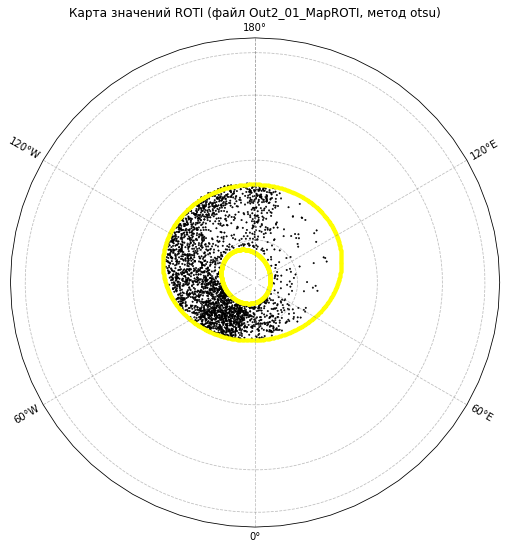

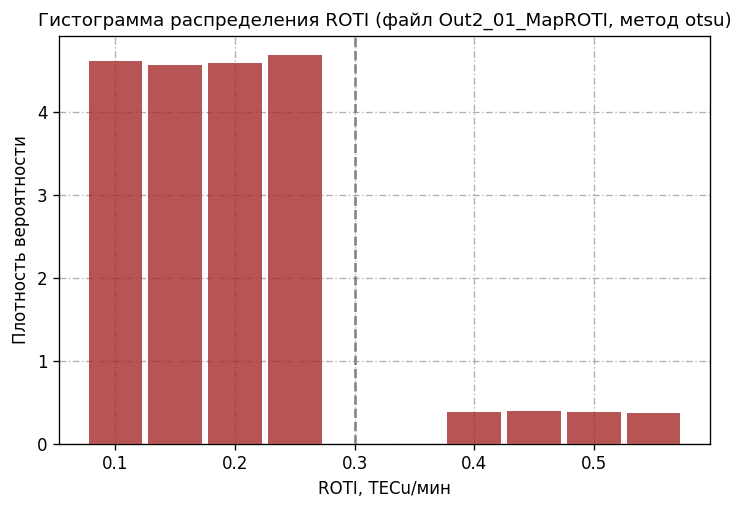

In [ ]:
start_time = time.time()
file_path = 'data/Synthetic_oval/Out2/01_MapROTI.dat'
method = 'otsu'
hour_minute_second = '00:30:00'
process_file(file_path, method, hour_minute_second=hour_minute_second)
stop_time = time.time()
print('Время: %.1f с' % (stop_time - start_time))

###Проход по всем модельным файлам методами (времязатратная операция)

kmeans
inner: Out1_01_MapROTI, 87.532828, -130.369710, 668, 784, 35.7
outer: Out1_01_MapROTI, 84.847733, -160.542588, 2356, 2222, 2.0
1069, 1676, 1537, 1831
otsu
inner: Out1_01_MapROTI, 87.537255, -130.438169, 670, 785, 35.8
outer: Out1_01_MapROTI, 84.842574, -160.376591, 2353, 2221, 1.8
1064, 1667, 1533, 1824
median
inner: Out1_01_MapROTI, 83.946867, -70.115324, 9756, 10524, 12.2
outer: Out1_01_MapROTI, 85.197833, -69.703787, 10782, 9968, -80.4
1560, 1659, 1724, 1950
quantile
inner: Out1_01_MapROTI, 84.491501, -145.427277, 1558, 1458, -55.4
outer: Out1_01_MapROTI, 84.760629, -150.023459, 1700, 1597, -46.9
209, 323, 268, 323
kmeans
inner: Out1_02_MapROTI, 87.526168, -129.962696, 666, 777, 36.4
outer: Out1_02_MapROTI, 84.826643, -159.707654, 2341, 2229, 1.2
1070, 1647, 1534, 1822
otsu
inner: Out1_02_MapROTI, 87.534161, -130.133350, 669, 779, 36.7
outer: Out1_02_MapROTI, 84.821745, -159.480283, 2337, 2227, 0.9
1063, 1633, 1528, 1817
median
inner: Out1_02_MapROTI, 83.871138, -68.991538, 1

/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


otsu
inner: Out1_17_MapROTI, 86.046867, -136.049627, 1049, 644, -63.0
outer: Out1_17_MapROTI, 85.024164, -168.211450, 2410, 2288, 0.6
1054, 1860, 1510, 1938


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


median
inner: Out1_17_MapROTI, 85.009629, -65.715672, 10641, 9862, -77.9
outer: Out1_17_MapROTI, 87.098488, -47.269057, 11304, 10734, -79.1
402, 662, 690, 1088
quantile
inner: Out1_17_MapROTI, 84.209676, -140.968440, 1540, 1348, -71.2
outer: Out1_17_MapROTI, 85.008293, -152.467063, 1787, 1663, -60.2
240, 533, 421, 565


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


kmeans
inner: Out1_18_MapROTI, 86.354892, -141.792795, 1032, 688, -78.0
outer: Out1_18_MapROTI, 85.213212, -159.635649, 2362, 2261, -34.1
1087, 1448, 1420, 1664


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


otsu
inner: Out1_18_MapROTI, 86.349750, -141.854621, 1034, 689, -78.1
outer: Out1_18_MapROTI, 85.211828, -159.549514, 2361, 2260, -34.2
1086, 1445, 1417, 1661


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


median
inner: Out1_18_MapROTI, 86.464621, 8.115823, 10445, 9969, 38.9
outer: Out1_18_MapROTI, 88.107136, 4.725288, 11457, 11018, -132.5
1054, 1082, 1237, 1464
quantile
inner: Out1_18_MapROTI, 82.725524, -140.162781, 1597, 1250, -82.8
outer: Out1_18_MapROTI, 83.037568, -137.213749, 1800, 1348, -83.4
81, 249, 163, 249


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


kmeans
inner: Out1_19_MapROTI, 83.486520, 177.920194, 958, 1345, -32.6
outer: Out1_19_MapROTI, 85.965523, -164.984326, 2426, 2297, -49.3
701, 1538, 1262, 1538


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


otsu
inner: Out1_19_MapROTI, 83.506906, 177.964708, 958, 1343, -32.7
outer: Out1_19_MapROTI, 85.967152, -164.882399, 2426, 2296, -49.5
705, 1536, 1262, 1536


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


median
inner: Out1_19_MapROTI, 80.980992, -56.622838, 9802, 9253, -83.6
outer: Out1_19_MapROTI, 83.698399, -54.524493, 10774, 10345, -62.5
1616, 1922, 1952, 2265
quantile
inner: Out1_19_MapROTI, 84.981291, -118.098390, 1083, 1621, 35.9
outer: Out1_19_MapROTI, 85.039138, -110.509630, 1237, 1679, 38.6
38, 87, 131, 230


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


kmeans
otsu
median
quantile
kmeans


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:191: RuntimeWarning: invalid value encountered in long_scalars
  ret = ret / rcount


inner: Out2_01_MapROTI, 87.379821, -126.066737, 817, 687, -54.2
outer: Out2_01_MapROTI, 84.924869, -165.180990, 2137, 2387, -86.8
940, 940, 1435, 1854
otsu
inner: Out2_01_MapROTI, 87.389877, -122.659143, 759, 648, -64.3
outer: Out2_01_MapROTI, 85.036504, -171.621988, 2166, 2494, -86.4
1026, 1026, 1555, 2090
median
inner: Out2_01_MapROTI, 84.919033, -78.778045, 10636, 9915, -85.7
outer: Out2_01_MapROTI, 85.929082, -81.487506, 10707, 10160, -83.8
186, 287, 275, 421
quantile
inner: Out2_01_MapROTI, 84.423875, -139.813044, 1352, 1634, -1.6
outer: Out2_01_MapROTI, 84.847724, -150.994136, 1579, 1766, -8.9
137, 365, 282, 416
kmeans
inner: Out2_02_MapROTI, 87.368125, -126.779410, 822, 693, -54.7
outer: Out2_02_MapROTI, 84.888807, -164.786206, 2132, 2383, -85.5
937, 937, 1429, 1853
otsu
inner: Out2_02_MapROTI, 87.385804, -123.144441, 760, 653, -65.0
outer: Out2_02_MapROTI, 85.011030, -171.269508, 2160, 2493, -85.4
1013, 1013, 1548, 2077
median
inner: Out2_02_MapROTI, 85.141306, -72.703652, 1064

/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


otsu
inner: Out2_13_MapROTI, 87.401774, -126.693573, 760, 647, -57.9
outer: Out2_13_MapROTI, 85.108803, 160.840254, 2904, 2139, -4.5
1020, 2570, 1871, 2570


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


median
inner: Out2_13_MapROTI, 83.883343, -84.592252, 10344, 9746, -88.1
outer: Out2_13_MapROTI, 86.394214, -84.608482, 10572, 10288, -69.8
1701, 1862, 1954, 2307
quantile
inner: Out2_13_MapROTI, 85.477101, -146.950778, 1462, 1599, 20.6
outer: Out2_13_MapROTI, 85.125653, -152.157773, 1766, 1650, -70.1
438, 462, 479, 534


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


kmeans
inner: Out2_14_MapROTI, 87.343027, -132.030051, 841, 705, -56.3
outer: Out2_14_MapROTI, 85.202551, 170.858676, 2723, 2089, -2.4
974, 2243, 1676, 2243


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


otsu
inner: Out2_14_MapROTI, 87.323140, -127.267135, 741, 635, -56.6
outer: Out2_14_MapROTI, 85.006288, 159.932330, 2901, 2145, -3.1
1029, 2605, 1888, 2605


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


median
inner: Out2_14_MapROTI, 83.664608, -85.532306, 10246, 9598, -89.4
outer: Out2_14_MapROTI, 86.191896, -81.335421, 10485, 10155, -56.4
225, 672, 559, 962
quantile
inner: Out2_14_MapROTI, 85.823943, -147.986029, 1440, 1566, 16.9
outer: Out2_14_MapROTI, 85.310358, -154.331272, 1757, 1622, -77.3
334, 388, 411, 513


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


kmeans
inner: Out2_15_MapROTI, 87.505954, -130.464470, 828, 676, -58.7
outer: Out2_15_MapROTI, 84.997028, -177.645365, 2132, 2536, -83.1
974, 974, 1512, 2117


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


otsu
inner: Out2_15_MapROTI, 87.403546, -126.243289, 596, 729, 30.5
outer: Out2_15_MapROTI, 84.904117, 168.022339, 2193, 2755, -85.9
1097, 1097, 1735, 2500


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


median
inner: Out2_15_MapROTI, 83.437676, -85.134471, 10293, 9548, -97.6
outer: Out2_15_MapROTI, 86.275290, -79.015215, 10375, 10063, -58.3
248, 864, 573, 995
quantile
inner: Out2_15_MapROTI, 85.019705, -144.468528, 1328, 1598, -5.3
outer: Out2_15_MapROTI, 84.760332, -148.499970, 1843, 1568, -95.3
470, 470, 496, 528


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


kmeans
inner: Out2_16_MapROTI, 87.611386, -128.611357, 688, 835, 36.2
outer: Out2_16_MapROTI, 85.209223, 174.351009, 2614, 2166, 1.0
969, 2116, 1649, 2131


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


otsu
inner: Out2_16_MapROTI, 87.469016, -124.018500, 730, 603, -55.2
outer: Out2_16_MapROTI, 84.964330, 156.711986, 2885, 2232, -2.4
1097, 2649, 1939, 2649


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


median
inner: Out2_16_MapROTI, 80.619923, -82.284997, 10077, 9222, -79.3
outer: Out2_16_MapROTI, 85.212064, -84.848035, 10428, 9976, -54.1
767, 1247, 1351, 1912
quantile
inner: Out2_16_MapROTI, 85.240806, -152.026000, 1305, 1626, -4.7
outer: Out2_16_MapROTI, 84.950835, -156.839058, 1845, 1560, -93.7
416, 416, 482, 537


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


kmeans
inner: Out2_17_MapROTI, 88.253131, -124.640361, 785, 670, -49.8
outer: Out2_17_MapROTI, 84.068257, 157.627449, 2927, 2141, 10.3
872, 2679, 1891, 2679


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


otsu
inner: Out2_17_MapROTI, 88.128051, -118.791107, 578, 659, 40.9
outer: Out2_17_MapROTI, 82.867626, 141.470200, 3273, 2257, 7.3
1058, 3339, 2260, 3339


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


median
inner: Out2_17_MapROTI, 84.870762, -79.956322, 10311, 9566, -111.8
outer: Out2_17_MapROTI, 85.105069, -69.762554, 10450, 9949, -72.8
232, 676, 500, 706
quantile
inner: Out2_17_MapROTI, 84.580219, -154.491124, 1608, 1371, -113.0
outer: Out2_17_MapROTI, 84.446513, -156.424142, 1798, 1622, -122.9
281, 322, 338, 377


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


kmeans
inner: Out2_18_MapROTI, 87.969682, -129.454771, 806, 669, -54.8
outer: Out2_18_MapROTI, 84.280244, 155.606566, 2145, 2918, -79.1
1026, 1026, 1716, 2699


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


otsu
inner: Out2_18_MapROTI, 87.799373, -127.220629, 689, 580, -57.0
outer: Out2_18_MapROTI, 83.075139, 139.931934, 3263, 2295, 8.3
1128, 3327, 2263, 3327


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


median
inner: Out2_18_MapROTI, 85.822039, -77.943668, 9867, 9916, 30.2
outer: Out2_18_MapROTI, 87.036672, -93.435057, 10666, 10320, -35.4
634, 1159, 982, 1159
quantile
inner: Out2_18_MapROTI, 83.679485, -145.302308, 1567, 1222, -98.3
outer: Out2_18_MapROTI, 83.954621, -150.789616, 1784, 1539, -116.3
340, 444, 483, 641


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


kmeans
inner: Out2_19_MapROTI, 88.233816, 175.258100, 804, 773, 10.0
outer: Out2_19_MapROTI, 84.161039, 154.155057, 2877, 2263, 7.9
1036, 2331, 1801, 2331


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


otsu
inner: Out2_19_MapROTI, 87.946390, 162.506769, 749, 676, -94.3
outer: Out2_19_MapROTI, 83.132340, 142.662698, 2392, 3185, -81.9
1327, 1331, 1978, 2872


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


median
inner: Out2_19_MapROTI, 83.283136, -91.619724, 10175, 9431, -113.7
outer: Out2_19_MapROTI, 88.701288, -122.334832, 10712, 10523, 28.6
113, 1580, 887, 1692
quantile
inner: Out2_19_MapROTI, 84.414441, -130.109542, 1033, 1329, -54.4
outer: Out2_19_MapROTI, 83.395750, -141.231434, 1284, 1579, -40.6
219, 414, 377, 581


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


kmeans
otsu
median
quantile
kmeans


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:191: RuntimeWarning: invalid value encountered in long_scalars
  ret = ret / rcount


inner: Out3_01_MapROTI, 86.049711, -149.372087, 819, 790, 10.0
outer: Out3_01_MapROTI, 86.387890, -151.315983, 2127, 2303, -92.8
1269, 1312, 1358, 1459
otsu
inner: Out3_01_MapROTI, 86.096821, -146.815508, 759, 741, 27.7
outer: Out3_01_MapROTI, 86.774514, -163.025368, 2130, 2452, -92.5
1361, 1361, 1496, 1756
median
inner: Out3_01_MapROTI, 84.228204, -65.841500, 10621, 9751, -85.7
outer: Out3_01_MapROTI, 85.013394, -67.230888, 9893, 10538, 0.5
1469, 1776, 1603, 1776
quantile
inner: Out3_01_MapROTI, 84.798164, -125.722006, 1522, 1349, -76.8
outer: Out3_01_MapROTI, 85.282219, -128.935912, 1664, 1518, -68.1
205, 329, 273, 338
kmeans
inner: Out3_02_MapROTI, 86.030921, -149.969325, 820, 793, 4.2
outer: Out3_02_MapROTI, 86.384206, -150.833754, 2125, 2303, -93.4
1274, 1330, 1370, 1468
otsu
inner: Out3_02_MapROTI, 86.073332, -147.538615, 755, 744, 28.3
outer: Out3_02_MapROTI, 86.767953, -163.236300, 2132, 2459, -91.8
1359, 1367, 1501, 1764
median
inner: Out3_02_MapROTI, 84.156734, -68.057324, 10

/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


otsu
inner: Out3_07_MapROTI, 86.240531, -146.694432, 763, 699, -14.7
outer: Out3_07_MapROTI, 86.762980, -165.484758, 2171, 2451, -91.4
1398, 1409, 1515, 1754


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


median
inner: Out3_07_MapROTI, 82.919130, -64.306006, 10587, 9730, -69.6
outer: Out3_07_MapROTI, 83.650998, -72.289507, 10796, 9904, -80.9
1192, 1208, 1256, 1334
quantile
inner: Out3_07_MapROTI, 84.205248, -118.632996, 1265, 1546, 19.8
outer: Out3_07_MapROTI, 84.654226, -122.814312, 1665, 1430, -67.7
312, 319, 400, 487


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


kmeans
inner: Out3_08_MapROTI, 86.266702, -150.028687, 840, 746, -12.8
outer: Out3_08_MapROTI, 86.440380, -151.768903, 2141, 2300, -96.6
1352, 1369, 1394, 1452


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


otsu
inner: Out3_08_MapROTI, 86.213761, -146.476114, 760, 700, -13.7
outer: Out3_08_MapROTI, 86.857330, -167.050540, 2174, 2465, -93.9
1405, 1419, 1531, 1791


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


median
inner: Out3_08_MapROTI, 82.773607, -63.346418, 10670, 9703, -70.0
outer: Out3_08_MapROTI, 83.518624, -69.754317, 10866, 9836, -79.2
948, 970, 1019, 1092
quantile
inner: Out3_08_MapROTI, 84.232292, -122.080226, 1566, 1263, -75.4
outer: Out3_08_MapROTI, 84.710461, -126.278089, 1703, 1432, -72.5
108, 206, 175, 249


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


kmeans
inner: Out3_09_MapROTI, 86.275587, -148.767670, 827, 745, -18.9
outer: Out3_09_MapROTI, 86.456607, -151.361559, 2142, 2297, -99.6
1347, 1354, 1388, 1457


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


otsu
inner: Out3_09_MapROTI, 86.266961, -145.148596, 742, 698, -17.3
outer: Out3_09_MapROTI, 86.884679, -165.246043, 2186, 2446, -96.4
1418, 1421, 1534, 1781


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


median
inner: Out3_09_MapROTI, 83.056992, -63.740401, 10588, 9726, -70.6
outer: Out3_09_MapROTI, 84.115282, -72.589499, 10798, 9956, -76.8
618, 618, 709, 820
quantile
inner: Out3_09_MapROTI, 84.242641, -121.319074, 1565, 1281, -75.7
outer: Out3_09_MapROTI, 84.736146, -124.780896, 1699, 1444, -70.8
133, 247, 199, 271


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


kmeans
inner: Out3_10_MapROTI, 86.185726, -147.730578, 828, 739, -24.1
outer: Out3_10_MapROTI, 86.450409, -148.439275, 2276, 2149, -18.3
1338, 1420, 1380, 1420


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


otsu
inner: Out3_10_MapROTI, 86.220831, -144.171554, 743, 682, -26.2
outer: Out3_10_MapROTI, 86.899460, -161.739059, 2189, 2419, -100.4
1422, 1432, 1524, 1744


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


median
inner: Out3_10_MapROTI, 82.950386, -63.220127, 10593, 9820, -70.0
outer: Out3_10_MapROTI, 84.080895, -68.367571, 9994, 10762, 9.6
675, 1052, 895, 1088
quantile
inner: Out3_10_MapROTI, 84.555970, -121.274087, 1520, 1278, -72.8
outer: Out3_10_MapROTI, 84.894862, -125.403737, 1676, 1438, -66.6
166, 269, 223, 283


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


kmeans
inner: Out3_11_MapROTI, 86.173572, -147.599772, 821, 738, -11.9
outer: Out3_11_MapROTI, 86.366032, -147.041405, 2267, 2133, -15.1
1326, 1402, 1368, 1402


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


otsu
inner: Out3_11_MapROTI, 86.242786, -144.596194, 735, 674, -9.6
outer: Out3_11_MapROTI, 86.834395, -159.842110, 2174, 2412, -99.1
1461, 1464, 1552, 1747


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


median
inner: Out3_11_MapROTI, 83.623202, -65.531222, 10558, 9920, -65.7
outer: Out3_11_MapROTI, 84.972339, -70.799918, 10849, 10106, -88.3
1287, 1390, 1509, 1805
quantile
inner: Out3_11_MapROTI, 85.438440, -126.296448, 1520, 1358, -52.0
outer: Out3_11_MapROTI, 85.672848, -130.993975, 1726, 1513, -50.6
108, 230, 186, 230


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


kmeans
inner: Out3_12_MapROTI, 85.857590, -147.283352, 815, 768, -69.9
outer: Out3_12_MapROTI, 85.760367, -137.456477, 2199, 2090, -67.5
1197, 1340, 1307, 1363


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


otsu
inner: Out3_12_MapROTI, 86.030596, -145.084087, 704, 718, 5.8
outer: Out3_12_MapROTI, 86.430231, -146.958722, 2293, 2191, -33.4
1409, 1568, 1481, 1568


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


median
inner: Out3_12_MapROTI, 84.592779, -60.043852, 9884, 10546, 22.7
outer: Out3_12_MapROTI, 85.221565, -68.625639, 10034, 10654, 6.7
1711, 1814, 1784, 1854
quantile
inner: Out3_12_MapROTI, 84.754778, -122.617645, 1236, 1585, 20.0
outer: Out3_12_MapROTI, 84.574041, -125.388515, 1388, 1766, 21.0
124, 167, 164, 207


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


kmeans
inner: Out3_13_MapROTI, 86.070164, -150.859743, 820, 759, -99.8
outer: Out3_13_MapROTI, 85.751926, -137.108405, 2191, 2093, -71.1
1154, 1350, 1317, 1418


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


otsu
inner: Out3_13_MapROTI, 86.233912, -148.334916, 678, 730, -26.5
outer: Out3_13_MapROTI, 86.455464, -146.435779, 2288, 2199, -32.8
1399, 1567, 1492, 1567


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


median
inner: Out3_13_MapROTI, 84.651284, -50.375407, 9759, 10404, 35.2
outer: Out3_13_MapROTI, 85.851260, -55.397345, 10798, 10111, -77.1
446, 536, 562, 768
quantile
inner: Out3_13_MapROTI, 84.401605, -123.953366, 1209, 1545, 11.5
outer: Out3_13_MapROTI, 84.299526, -124.672265, 1727, 1388, -76.0
356, 378, 413, 483


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


kmeans
inner: Out3_14_MapROTI, 86.635641, -147.970183, 744, 817, -120.4
outer: Out3_14_MapROTI, 85.918744, -139.397472, 2192, 2121, -68.3
1231, 1326, 1361, 1463


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


otsu
inner: Out3_14_MapROTI, 86.719618, -143.899918, 702, 662, -29.6
outer: Out3_14_MapROTI, 86.561168, -148.991869, 2305, 2212, -25.6
1453, 1544, 1518, 1549


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


median
inner: Out3_14_MapROTI, 84.064845, -54.381117, 10308, 9654, -52.8
outer: Out3_14_MapROTI, 85.426063, -62.829430, 10122, 10696, 19.0
220, 538, 420, 718
quantile
inner: Out3_14_MapROTI, 84.382445, -124.964825, 1573, 1192, -79.3
outer: Out3_14_MapROTI, 84.468980, -125.904885, 1740, 1381, -76.3
169, 187, 187, 213


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


kmeans
inner: Out3_15_MapROTI, 86.400836, -146.551707, 751, 855, -118.4
outer: Out3_15_MapROTI, 85.975135, -146.336593, 2213, 2161, -122.0
1225, 1388, 1339, 1426


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


otsu
inner: Out3_15_MapROTI, 86.499796, -142.028105, 725, 661, -30.1
outer: Out3_15_MapROTI, 86.428853, -162.173197, 2376, 2252, 21.3
1476, 1789, 1603, 1789


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


median
inner: Out3_15_MapROTI, 83.719848, -38.622706, 10363, 9630, -61.3
outer: Out3_15_MapROTI, 86.364510, -47.874056, 10237, 10607, 7.1
284, 702, 638, 1033
quantile
inner: Out3_15_MapROTI, 84.287647, -124.152996, 1225, 1550, 23.0
outer: Out3_15_MapROTI, 84.183407, -124.489681, 1745, 1379, -64.5
346, 393, 415, 482


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


kmeans
inner: Out3_16_MapROTI, 86.689724, -162.713162, 1000, 721, 0.2
outer: Out3_16_MapROTI, 86.605149, -169.188780, 2440, 2143, 2.3
1332, 1422, 1376, 1423


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


otsu
inner: Out3_16_MapROTI, 86.799886, -149.516944, 807, 607, -2.6
outer: Out3_16_MapROTI, 86.544902, 169.547924, 2636, 2221, 4.4
1455, 2021, 1696, 2021


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


median
inner: Out3_16_MapROTI, 81.646872, -32.710315, 10376, 9500, -58.0
outer: Out3_16_MapROTI, 86.380884, -37.415938, 10352, 10545, -0.8
1295, 1707, 1770, 2259
quantile
inner: Out3_16_MapROTI, 84.133581, -130.592161, 1616, 1250, -71.8
outer: Out3_16_MapROTI, 84.238661, -132.763615, 1812, 1483, -72.0
183, 187, 205, 247


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


kmeans
inner: Out3_17_MapROTI, 86.612549, -164.719703, 948, 751, 2.4
outer: Out3_17_MapROTI, 86.602610, -171.192915, 2390, 2151, 2.8
1319, 1425, 1367, 1425


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


otsu
inner: Out3_17_MapROTI, 86.876427, -153.549937, 742, 631, 1.2
outer: Out3_17_MapROTI, 86.476556, 168.816369, 2601, 2225, 6.4
1443, 2027, 1700, 2027


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


median
inner: Out3_17_MapROTI, 83.318010, -38.608534, 10028, 9624, -34.2
outer: Out3_17_MapROTI, 86.568429, -55.282232, 10640, 10366, -84.2
1350, 1437, 1635, 1987
quantile
inner: Out3_17_MapROTI, 84.564694, -133.284832, 1620, 1211, -79.3
outer: Out3_17_MapROTI, 84.796101, -136.250543, 1809, 1507, -79.1
181, 191, 233, 317


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


kmeans
inner: Out3_18_MapROTI, 77.199000, -32.756218, 10123, 9079, -40.7
outer: Out3_18_MapROTI, 79.944194, -25.251093, 10648, 9609, -34.5
553, 1005, 845, 1118
otsu
inner: Out3_18_MapROTI, 86.862546, -168.577766, 1145, 702, 12.5
outer: Out3_18_MapROTI, 87.057007, 135.976779, 2851, 1930, -7.5
1114, 2053, 1493, 2053


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


median
inner: Out3_18_MapROTI, 78.902333, -48.440417, 10764, 9382, -74.9
outer: Out3_18_MapROTI, 83.561466, -44.845032, 11183, 10111, -72.4
85, 593, 662, 1226
quantile
inner: Out3_18_MapROTI, 83.536227, -127.363665, 1632, 1215, -101.9
outer: Out3_18_MapROTI, 85.072847, -138.469371, 1894, 1632, -98.9
195, 379, 369, 618


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


kmeans
inner: Out3_19_MapROTI, 84.131838, 164.413544, 1487, 731, 39.7
outer: Out3_19_MapROTI, 80.154922, 123.765500, 3496, 2074, 14.1
990, 2849, 1783, 2849


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


otsu
inner: Out3_19_MapROTI, 83.620519, 162.033636, 1531, 720, 41.1
outer: Out3_19_MapROTI, 79.434026, 122.860230, 3582, 2111, 14.8
993, 2936, 1831, 2936


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


median
inner: Out3_19_MapROTI, 83.845502, -33.541944, 10278, 9720, -98.7
outer: Out3_19_MapROTI, 82.194142, -55.582841, 11114, 10161, -55.1
825, 995, 1245, 1910
quantile
inner: Out3_19_MapROTI, 82.547013, -135.021381, 1707, 1087, -85.5
outer: Out3_19_MapROTI, 83.107315, -132.112417, 1929, 1252, -87.6
123, 291, 209, 291


/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/usr/local/lib/python3.8/dist-packages/cartopy/mpl/gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:


kmeans
otsu
median
quantile
kmeans


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:191: RuntimeWarning: invalid value encountered in long_scalars
  ret = ret / rcount


inner: Out4_01_MapROTI, 85.924866, -148.645753, 801, 832, -74.6
outer: Out4_01_MapROTI, 86.083744, -147.766866, 2193, 2215, 17.5
1351, 1351, 1372, 1406
otsu
inner: Out4_01_MapROTI, 85.924138, -148.656221, 801, 832, -74.6
outer: Out4_01_MapROTI, 86.083157, -147.761206, 2193, 2214, 17.3
1352, 1352, 1373, 1406
median
inner: Out4_01_MapROTI, 88.922274, 159.612455, 10532, 10082, -128.7
outer: Out4_01_MapROTI, 89.058081, -162.008708, 10590, 10092, -127.3
104, 162, 171, 213
quantile
inner: Out4_01_MapROTI, 86.007853, -147.878020, 1535, 1435, -131.4
outer: Out4_01_MapROTI, 85.967789, -152.502956, 1675, 1609, -120.6
272, 315, 320, 362
kmeans
inner: Out4_02_MapROTI, 85.924183, -148.900290, 807, 839, -82.9
outer: Out4_02_MapROTI, 86.084815, -148.288523, 2191, 2218, 23.9
1297, 1297, 1319, 1357
otsu
inner: Out4_02_MapROTI, 85.922693, -148.900539, 808, 839, -83.2
outer: Out4_02_MapROTI, 86.084545, -148.288685, 2191, 2217, 24.0
1297, 1297, 1319, 1357
median
inner: Out4_02_MapROTI, 88.768379, 158.8523

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:191: RuntimeWarning: invalid value encountered in long_scalars
  ret = ret / rcount


inner: Out5_01_MapROTI, 89.475702, 120.142575, 10534, 10007, -132.4
outer: Out5_01_MapROTI, 89.378616, 178.721294, 10495, 9987, -133.2
45, 137, 113, 138
otsu
inner: Out5_01_MapROTI, 89.380967, 126.761078, 10453, 9941, -132.9
outer: Out5_01_MapROTI, 89.318918, 173.280101, 10425, 9906, -133.1
24, 64, 66, 93
median
inner: Out5_01_MapROTI, 89.435182, 123.497550, 10529, 10000, -132.6
outer: Out5_01_MapROTI, 89.365878, 175.524304, 10491, 9983, -133.2
28, 116, 96, 118
quantile
inner: Out5_01_MapROTI, 84.860466, -154.705759, 1508, 1559, -68.6
outer: Out5_01_MapROTI, 85.120498, -154.576596, 1618, 1668, -91.4
319, 392, 367, 395
kmeans
inner: Out5_02_MapROTI, 89.321338, 125.727376, 10537, 10010, -132.2
outer: Out5_02_MapROTI, 89.129616, 161.381059, 10481, 10019, -131.9
30, 70, 71, 107
otsu
inner: Out5_02_MapROTI, 89.575809, 130.721201, 10486, 9933, -133.0
outer: Out5_02_MapROTI, 89.340427, -178.172086, 10450, 9939, -132.2
47, 63, 102, 143
median
inner: Out5_02_MapROTI, 89.314616, 129.100974, 1053

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:191: RuntimeWarning: invalid value encountered in long_scalars
  ret = ret / rcount


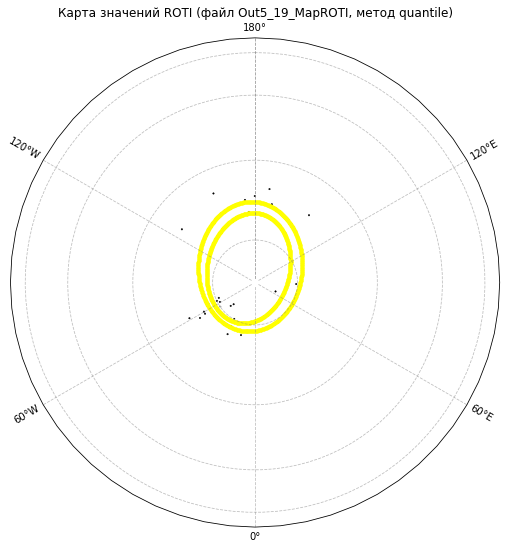

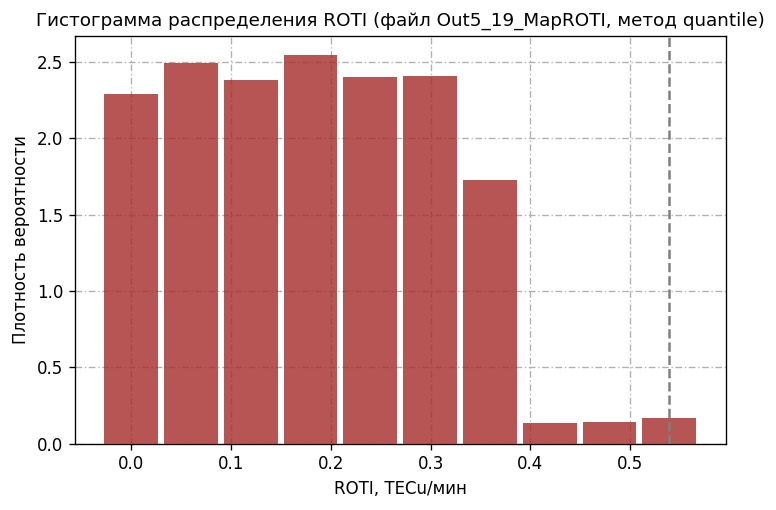

In [ ]:
#file_path = 'data/Synthetic_oval/Out2/01_MapROTI.dat'
#file_path = 'data/hdf5/roti_2022_091_-90_90_N_-180_180_E_f157.h5'

hour_minute_second = '00:30:00'

file_paths = gl.glob('data/Synthetic_oval/*/*_MapROTI.dat')

file_paths.sort()

for file_path in file_paths:

    for method in ['kmeans', 'otsu', 'median', 'quantile']:
        print(method)

        try:
            process_file(file_path, method, hour_minute_second=hour_minute_second)
        except:
            continue

### Анализ данных

In [ ]:
# параметры овала из модельных данных
oval_center_lat = 86.0
oval_center_lon = -147.0
oval_radius = 2200.0

df = pd.read_csv('parameters_for_model_data_3.csv')

df['oval_center_lat'] = oval_center_lat
df['oval_center_lon'] = oval_center_lon
df['oval_radius'] = oval_radius

# расстояние между центрами овалов
df['inner_center_diff'] = df.apply(lambda x: distance_geopy(x['inner_ellipse_center_lat'], x['inner_ellipse_center_lon'], x['oval_center_lat'], x['oval_center_lon']), axis=1)
df['outer_center_diff'] = df.apply(lambda x: distance_geopy(x['outer_ellipse_center_lat'], x['outer_ellipse_center_lon'], x['oval_center_lat'], x['oval_center_lon']), axis=1)

# haversine()
df['inner_center_diff_haversine'] = df.apply(lambda x: distance_haversine(x['inner_ellipse_center_lat'], x['inner_ellipse_center_lon'], x['oval_center_lat'], x['oval_center_lon']), axis=1)
df['outer_center_diff_haversine'] = df.apply(lambda x: distance_haversine(x['outer_ellipse_center_lat'], x['outer_ellipse_center_lon'], x['oval_center_lat'], x['oval_center_lon']), axis=1)

# ошибки определения радиуса внешнего эллипса
df['outer_width_diff']  = np.abs(df['outer_ellipse_width'] - df['oval_radius'])
df['outer_height_diff'] = np.abs(df['outer_ellipse_height'] - df['oval_radius'])

df

,file_name,method,inner_ellipse_center_lat,inner_ellipse_center_lon,inner_ellipse_width,inner_ellipse_height,inner_ellipse_angle,outer_ellipse_center_lat,outer_ellipse_center_lon,outer_ellipse_width,...,distance_max,oval_center_lat,oval_center_lon,oval_radius,inner_center_diff,outer_center_diff,inner_center_diff_haversine,outer_center_diff_haversine,outer_width_diff,outer_height_diff
0,Out1_01_MapROTI,kmeans,87.532828,-130.369710,668,784,35.7,84.847733,-160.542588,2356,...,1831,86.0,-147.0,2200.0,198.996107,175.582020,207.441160,183.036649,156.0,22.0
1,Out1_01_MapROTI,otsu,87.537255,-130.438169,670,785,35.8,84.842574,-160.376591,2353,...,1824,86.0,-147.0,2200.0,199.165147,175.058693,207.617381,182.491176,153.0,21.0
2,Out1_01_MapROTI,median,83.946867,-70.115324,9756,10524,12.2,85.197833,-69.703787,10782,...,1950,86.0,-147.0,2200.0,720.344137,617.612981,750.918056,643.819330,8582.0,7768.0
3,Out1_01_MapROTI,quantile,84.491501,-145.427277,1558,1458,-55.4,84.760629,-150.023459,1700,...,323,86.0,-147.0,2200.0,169.090570,141.020271,176.273974,147.010395,500.0,603.0
4,Out1_02_MapROTI,kmeans,87.526168,-129.962696,666,777,36.4,84.826643,-159.707654,2341,...,1822,86.0,-147.0,2200.0,199.700957,172.609851,208.175882,179.938635,141.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,Out5_18_MapROTI,quantile,85.074027,-153.584110,1393,1515,-19.2,84.661836,-156.817780,1595,...,360,86.0,-147.0,2200.0,118.031634,173.556988,123.043741,180.927642,605.0,454.0
376,Out5_19_MapROTI,kmeans,87.940717,-89.427765,9856,10460,-66.8,87.663024,-154.580569,10586,...,1196,86.0,-147.0,2200.0,377.143250,191.147244,393.144396,199.259853,8386.0,8038.0
377,Out5_19_MapROTI,otsu,89.297302,-0.369757,10318,9538,27.4,87.472874,179.987015,10366,...,1559,86.0,-147.0,2200.0,514.128940,260.277018,535.940767,271.320831,8166.0,7886.0
378,Out5_19_MapROTI,median,87.819042,-88.725853,9894,10488,-66.6,87.756303,-151.276424,10631,...,1323,86.0,-147.0,2200.0,380.016680,197.743687,396.139597,206.136262,8431.0,8065.0


Данные о расстоянии между границами овала

In [ ]:
df[['file_name', 'method', 'distance_min', 'distance_mean', 'distance_modal', 'distance_max']]

,file_name,method,distance_min,distance_mean,distance_modal,distance_max
0,Out1_01_MapROTI,kmeans,1069,1537,1676,1831
1,Out1_01_MapROTI,otsu,1064,1533,1667,1824
2,Out1_01_MapROTI,median,1560,1724,1659,1950
3,Out1_01_MapROTI,quantile,209,268,323,323
4,Out1_02_MapROTI,kmeans,1070,1534,1647,1822
...,...,...,...,...,...,...
375,Out5_18_MapROTI,quantile,234,297,318,360
376,Out5_19_MapROTI,kmeans,328,813,851,1196
377,Out5_19_MapROTI,otsu,635,1133,1086,1559
378,Out5_19_MapROTI,median,496,994,1065,1323


Ошибки определения центра овала

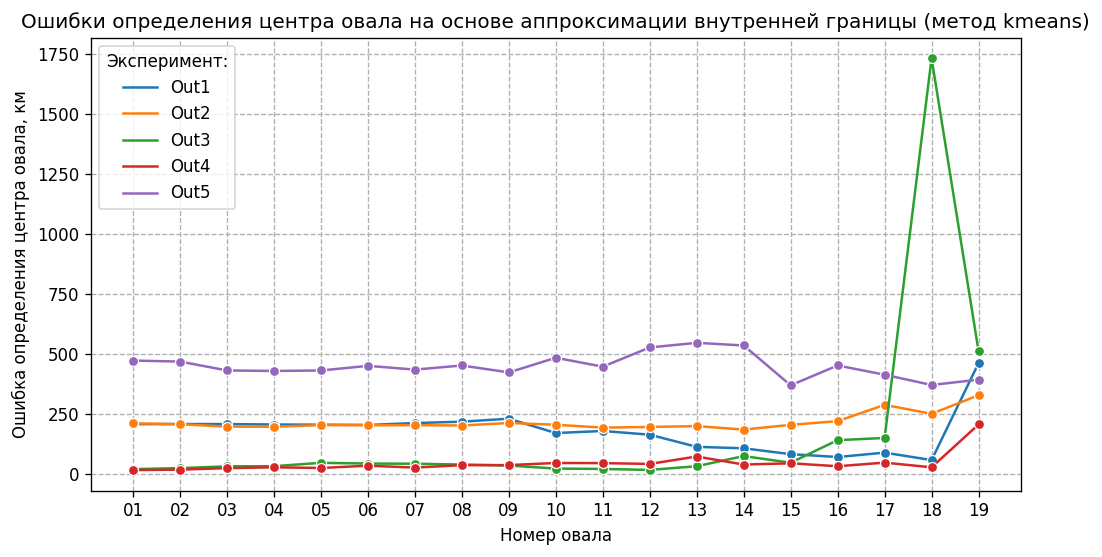

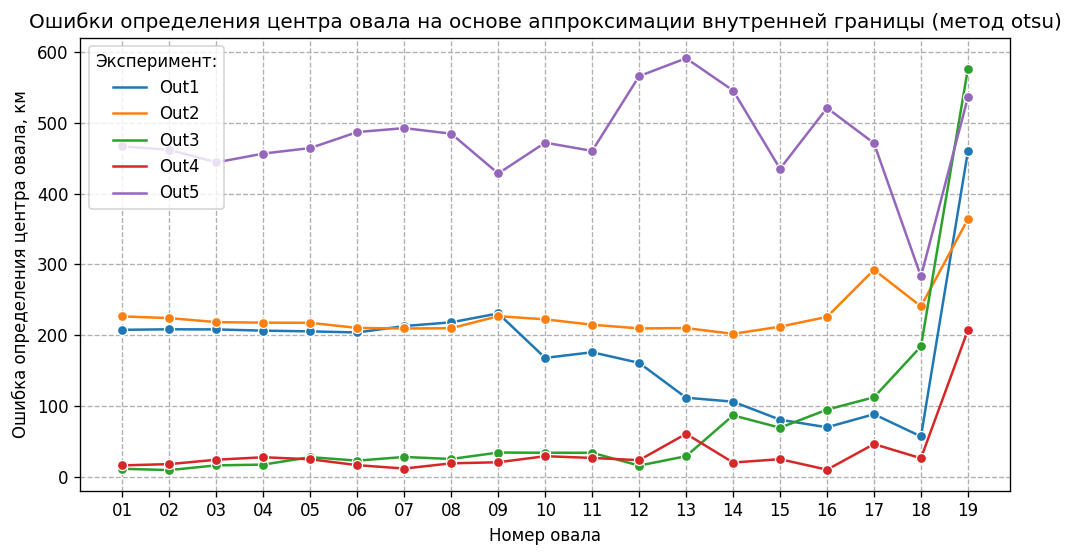

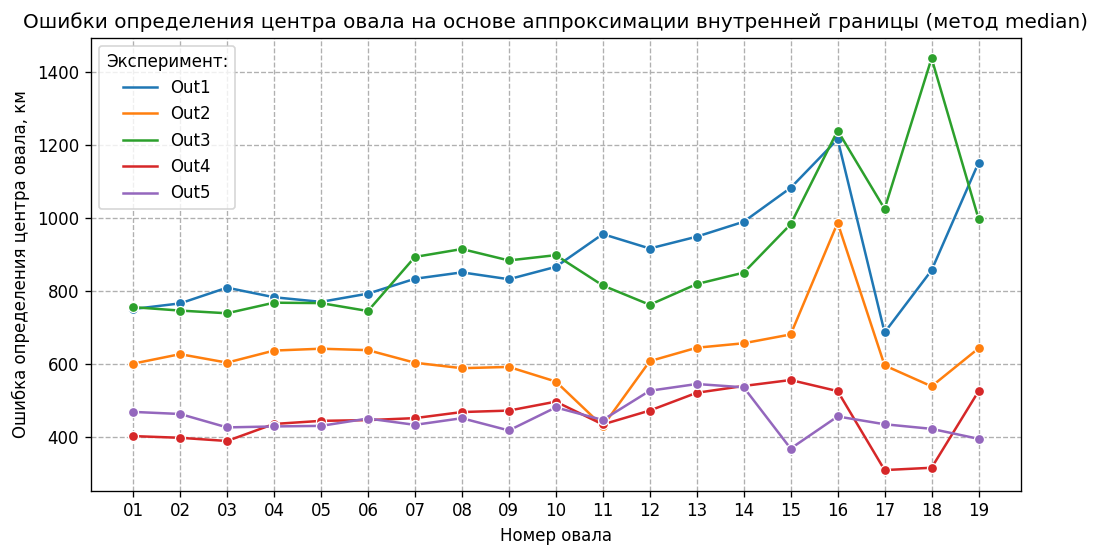

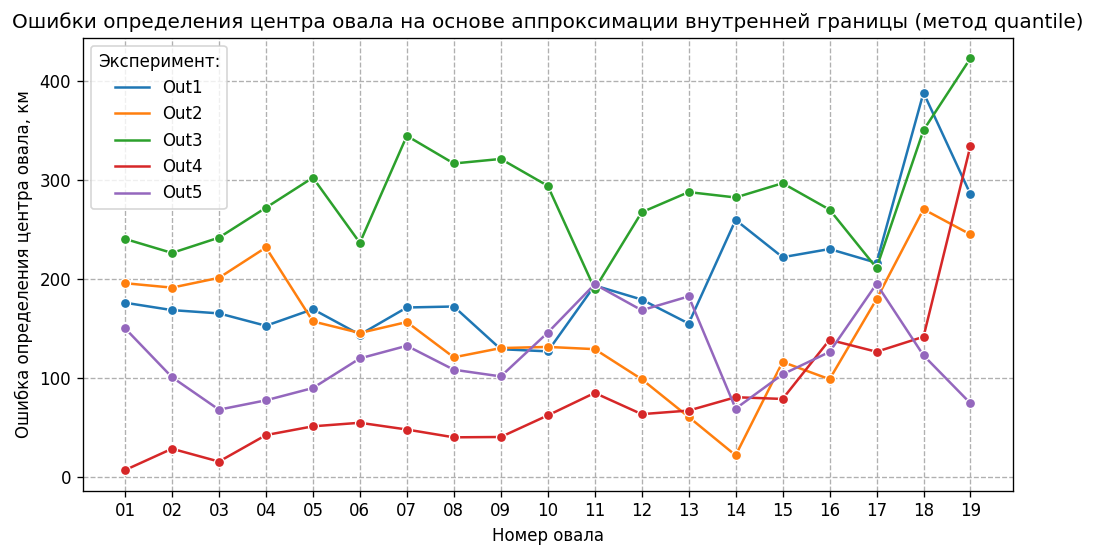

Таблица 1 - Абсолютные ошибки определения положения центра овала на основе аппроксимации внутренней границы


method,kmeans,otsu,median,quantile
experiment_id,,,,
Out1,179,178,887,195
Out2,216,229,625,152
Out3,161,75,897,283
Out4,45,34,454,79
Out5,449,477,453,123


Таблица 2 - Среднеквадратические ошибки определения положения центра овала на основе аппроксимации внутренней границы


method,kmeans,otsu,median,quantile
experiment_id,,,,
Out1,199,198,898,205
Out2,219,232,633,164
Out3,419,147,914,288
Out4,60,55,459,106
Out5,452,481,455,129


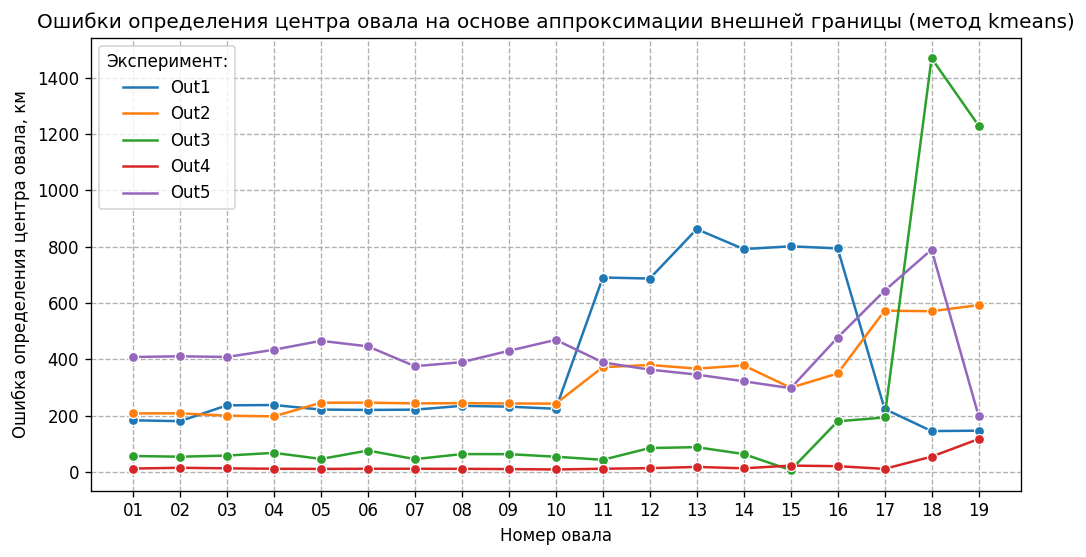

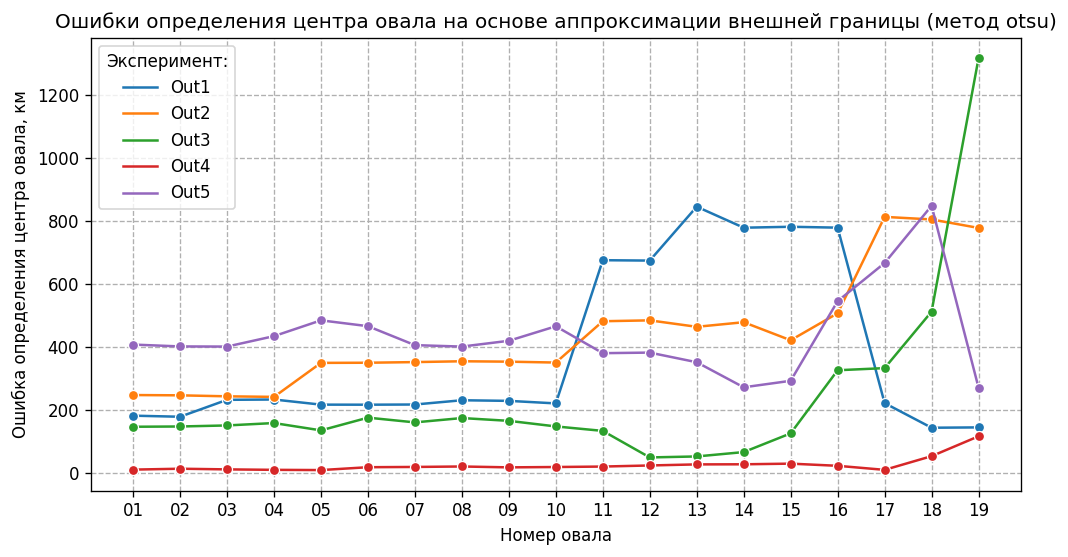

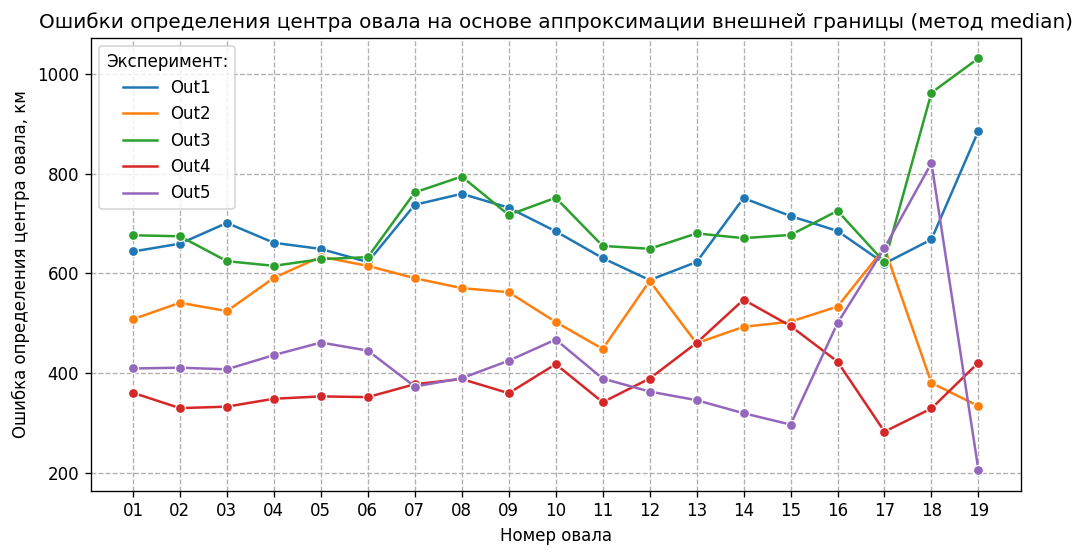

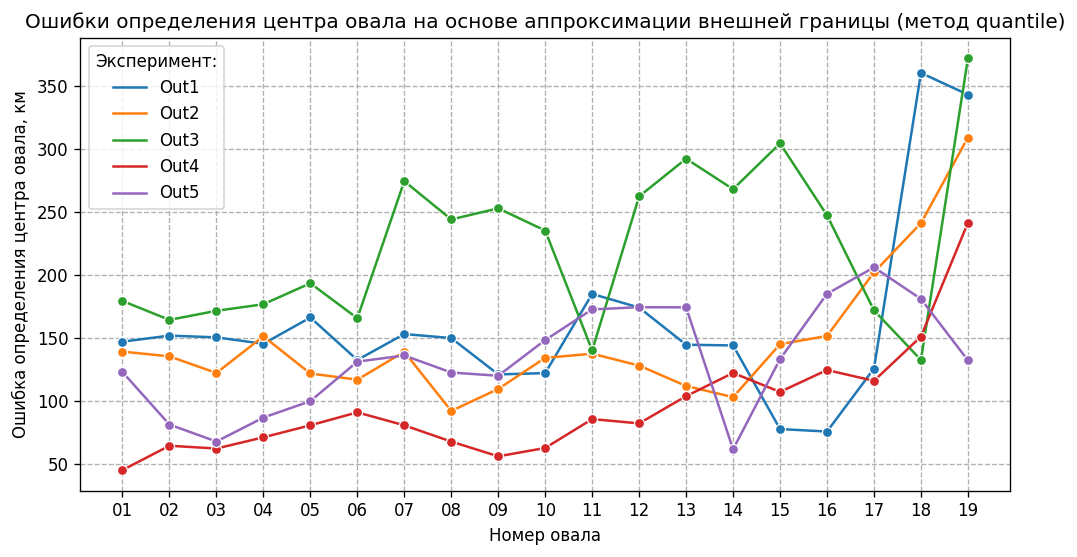

Таблица 3 - Абсолютные ошибки определения положения центра овала на основе аппроксимации внешней границы


method,kmeans,otsu,median,quantile
experiment_id,,,,
Out1,386,379,685,162
Out2,324,438,528,147
Out3,207,236,713,224
Out4,20,26,385,95
Out5,424,437,428,133


Таблица 4 - Среднеквадратические ошибки определения положения центра овала на основе аппроксимации внешней границы


method,kmeans,otsu,median,quantile
experiment_id,,,,
Out1,468,459,688,176
Out2,348,473,534,155
Out3,447,363,721,232
Out4,32,35,390,105
Out5,441,456,446,140


In [ ]:
methods = [' kmeans', ' otsu', ' median', ' quantile']
#methods = [' kmeans', ' otsu']

# сводная таблица с ошибками определения центра овала - внешняя граница (эллипс)
inner_center_diff = df.pivot_table('inner_center_diff_haversine', index='file_name', columns='method', aggfunc='mean').reset_index()
# название эксперимента (Out1, Out2, Out3, Out4, Out5)
inner_center_diff['experiment_id'] = inner_center_diff['file_name'].str.split('_').str[0]
# номер овала (01, 02, 03, 04, ... 18, 19)
inner_center_diff['oval_id'] = inner_center_diff['file_name'].str.split('_').str[1]

for method in methods:
    fig, ax = plt.subplots(figsize=(10, 5), dpi=120)
    sns.lineplot(data=inner_center_diff, x='oval_id', y=method, hue='experiment_id', marker='o')
    plt.title('Ошибки определения центра овала на основе аппроксимации внутренней границы (метод%s)'%method)
    plt.xlabel('Номер овала')
    plt.ylabel('Ошибка определения центра овала, км')
    plt.legend(title='Эксперимент:')
    plt.grid(axis='both', linestyle='--', zorder=-2)
    plt.savefig('images/errors-inner-center-%s.png'%(method.strip()), dpi=120)
    plt.show()

print('Таблица 1 - Абсолютные ошибки определения положения центра овала на основе аппроксимации внутренней границы')
display(inner_center_diff.groupby(['experiment_id'])[methods].agg('mean').round(0).astype(int))
print('Таблица 2 - Среднеквадратические ошибки определения положения центра овала на основе аппроксимации внутренней границы')
display(inner_center_diff.groupby(['experiment_id'])[methods].agg(rmse).round(0).astype(int))

# внутренний эллипс
outer_center_diff = df.pivot_table('outer_center_diff_haversine', index='file_name', columns='method', aggfunc='mean').reset_index()
outer_center_diff['experiment_id'] = outer_center_diff['file_name'].str.split('_').str[0]
outer_center_diff['oval_id'] = outer_center_diff['file_name'].str.split('_').str[1]

for method in methods:
    fig, ax = plt.subplots(figsize=(10, 5), dpi=120)
    sns.lineplot(data=outer_center_diff, x='oval_id', y=method, hue='experiment_id', marker='o')
    plt.title('Ошибки определения центра овала на основе аппроксимации внешней границы (метод%s)'%method)
    plt.xlabel('Номер овала')
    plt.ylabel('Ошибка определения центра овала, км')
    plt.legend(title='Эксперимент:')
    plt.grid(axis='both', linestyle='--', zorder=-2)
    plt.savefig('images/errors-outer-center-%s.png'%(method.strip()), dpi=120)
    plt.show()

print('Таблица 3 - Абсолютные ошибки определения положения центра овала на основе аппроксимации внешней границы')
display(outer_center_diff.groupby(['experiment_id'])[methods].agg('mean').round(0).astype(int))
print('Таблица 4 - Среднеквадратические ошибки определения положения центра овала на основе аппроксимации внешней границы')
display(outer_center_diff.groupby(['experiment_id'])[methods].agg(rmse).round(0).astype(int))

Отображаем ошибки определения радиуса овала

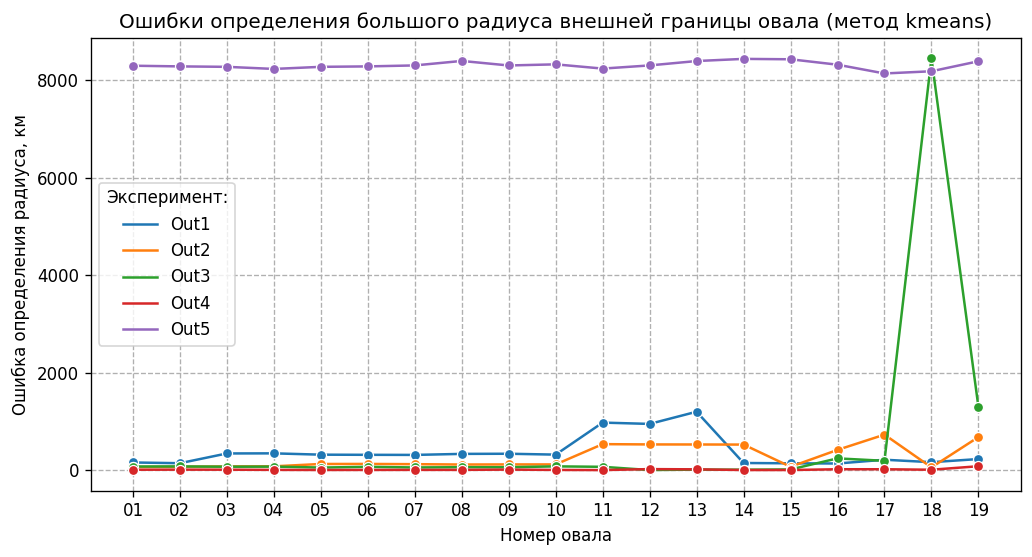

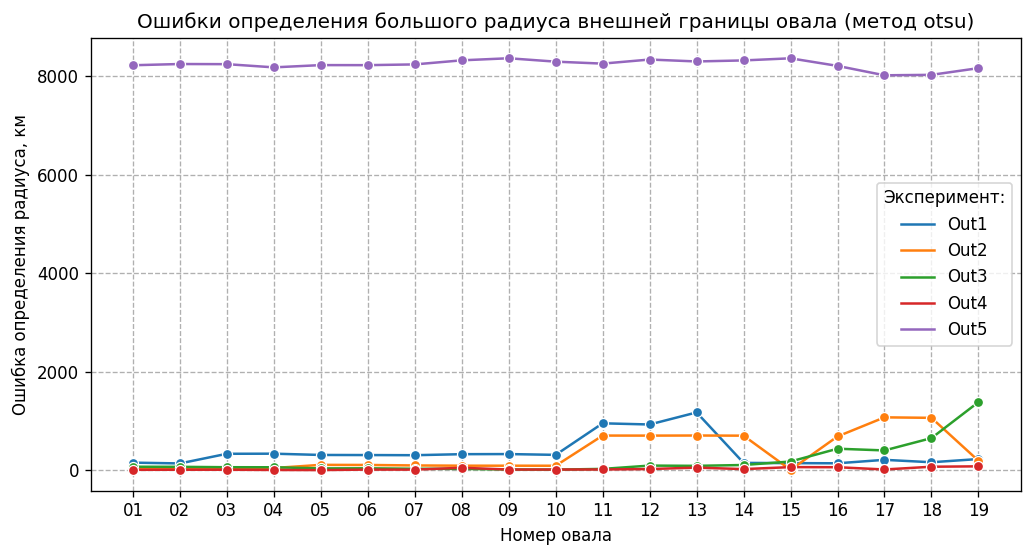

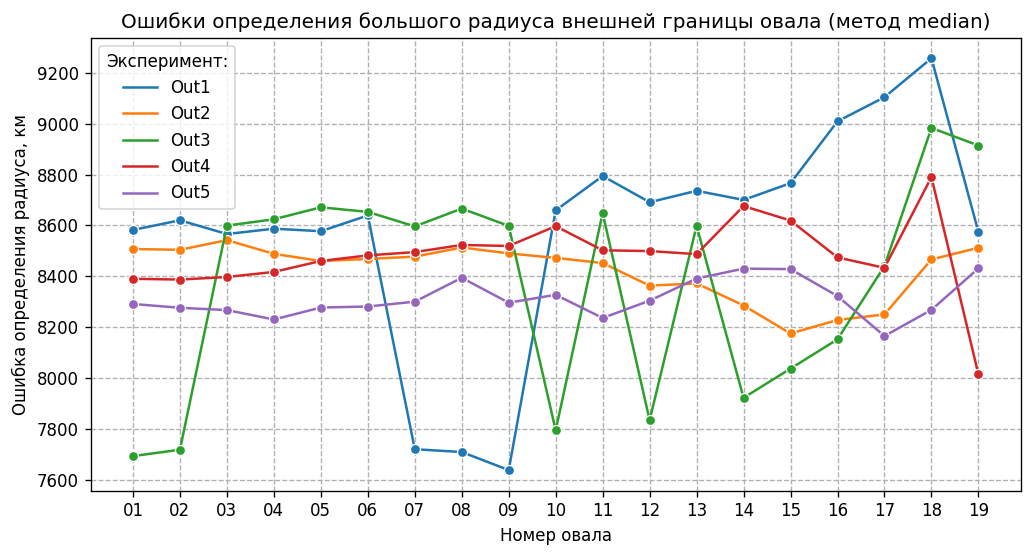

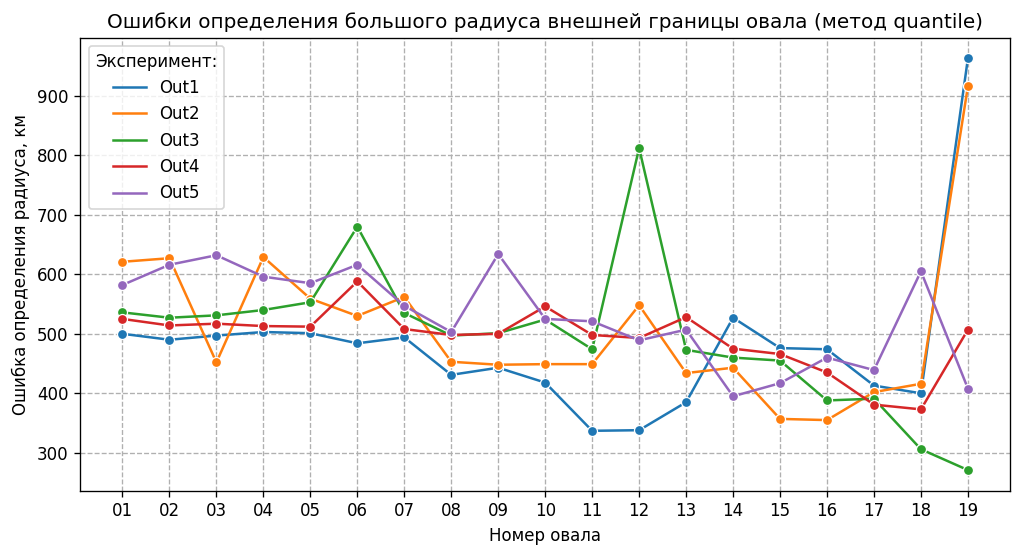

Таблица 5 - Абсолютные ошибки определения большого радиуса внешней границы овала


method,kmeans,otsu,median,quantile
experiment_id,,,,
Out1,371,364,8575,478
Out2,266,346,8422,508
Out3,575,198,8376,498
Out4,11,28,8482,494
Out5,8303,8243,8311,530


Таблица 6 - Среднеквадратические ошибки определения большого радиуса внешней границы овала


method,kmeans,otsu,median,quantile
experiment_id,,,,
Out1,479,469,8586,494
Out2,354,504,8423,524
Out3,1963,381,8386,511
Out4,20,37,8483,496
Out5,8303,8243,8312,536


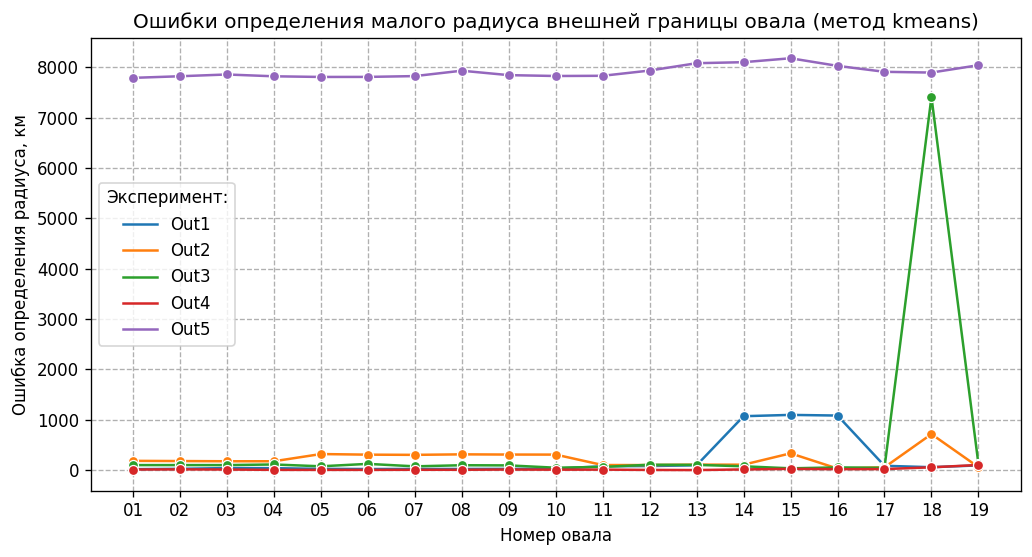

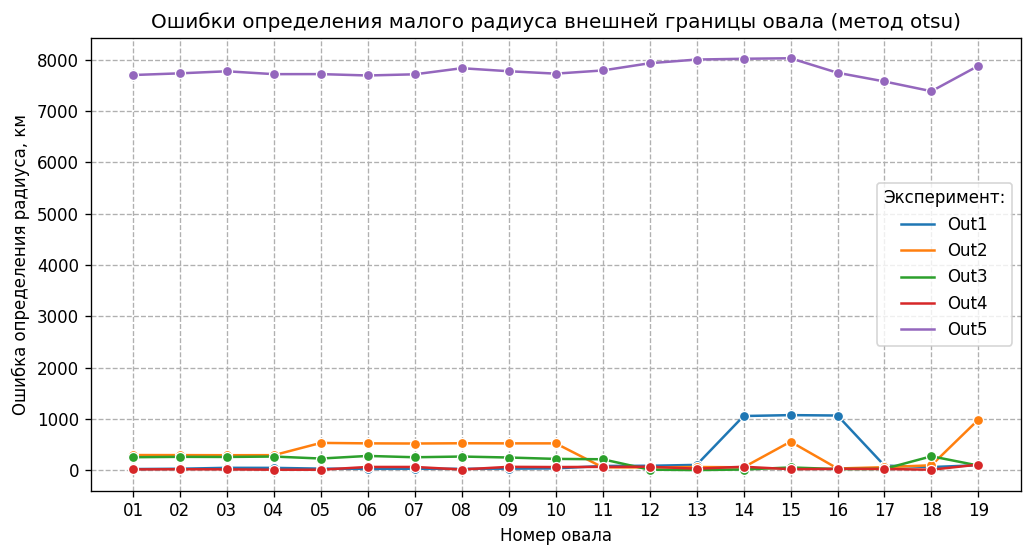

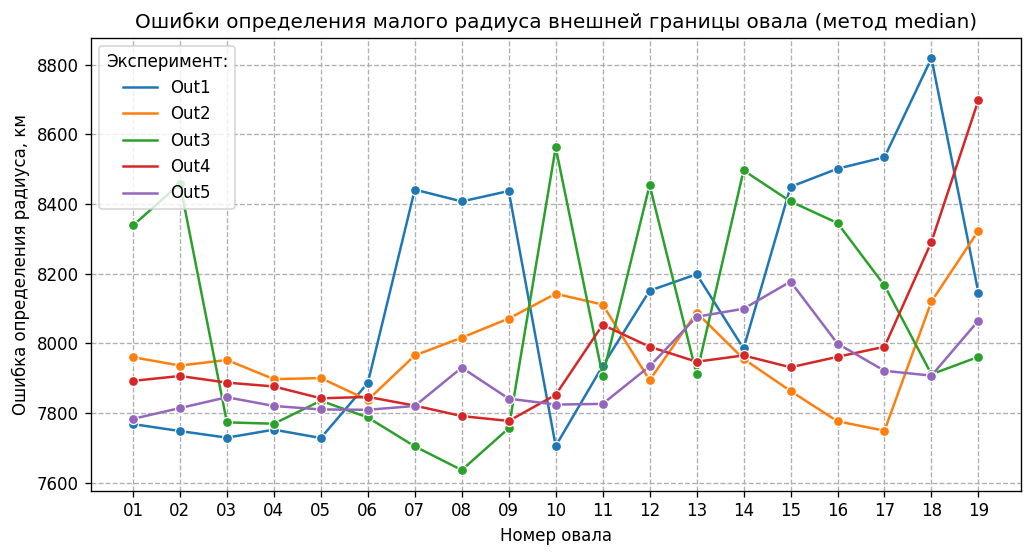

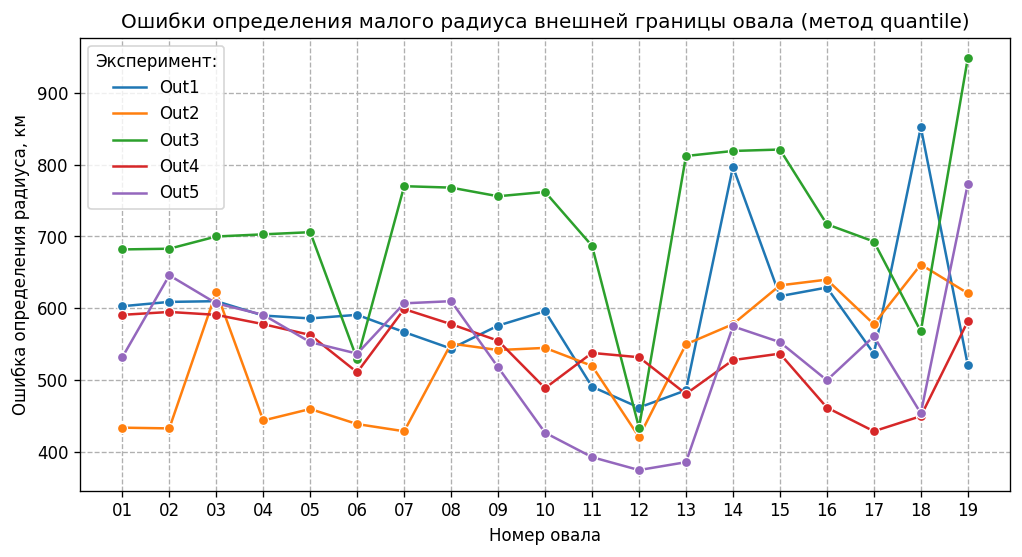

Таблица 7 - Абсолютные ошибки определения малого радиуса внешней границы овала


method,kmeans,otsu,median,quantile
experiment_id,,,,
Out1,214,211,8122,593
Out2,223,329,7977,532
Out3,474,169,8062,714
Out4,21,38,7964,536
Out5,7909,7781,7911,537


Таблица 8 - Среднеквадратические ошибки определения малого радиуса внешней границы овала


method,kmeans,otsu,median,quantile
experiment_id,,,,
Out1,435,426,8129,600
Out2,272,416,7978,538
Out3,1702,201,8068,722
Out4,31,48,7967,539
Out5,7910,7783,7911,545


In [ ]:
# сводная таблица с ошибками определения большого радиуса внешней границы овала
outer_width_diff = df.pivot_table('outer_width_diff', index='file_name', columns='method', aggfunc='mean').reset_index()
# сводная таблица с ошибками определения центра овала
outer_width_diff = df.pivot_table('outer_width_diff', index='file_name', columns='method', aggfunc='mean').reset_index()
outer_width_diff['experiment_id'] = outer_width_diff['file_name'].str.split('_').str[0]
outer_width_diff['oval_id'] = outer_width_diff['file_name'].str.split('_').str[1]

for method in methods:
    fig, ax = plt.subplots(figsize=(10, 5), dpi=120)
    sns.lineplot(data=outer_width_diff, x='oval_id', y=method, hue='experiment_id', marker='o')
    plt.title('Ошибки определения большого радиуса внешней границы овала (метод%s)'%method)
    plt.xlabel('Номер овала')
    plt.ylabel('Ошибка определения радиуса, км')
    plt.legend(title='Эксперимент:')
    plt.grid(axis='both', linestyle='--', zorder=-2)
    plt.savefig('images/errors-outer-width-%s.png'%(method.strip()), dpi=120)
    plt.show()

print('Таблица 5 - Абсолютные ошибки определения большого радиуса внешней границы овала')
display(outer_width_diff.groupby(['experiment_id'])[methods].agg('mean').round(0).astype(int))
print('Таблица 6 - Среднеквадратические ошибки определения большого радиуса внешней границы овала')
display(outer_width_diff.groupby(['experiment_id'])[methods].agg(rmse).round(0).astype(int))


# ошибки определения малого радиуса внешней границы овала
outer_height_diff = df.pivot_table('outer_height_diff', index='file_name', columns='method', aggfunc='mean').reset_index()
# ошибки определения центра овала
outer_height_diff = df.pivot_table('outer_height_diff', index='file_name', columns='method', aggfunc='mean').reset_index()
outer_height_diff['experiment_id'] = outer_height_diff['file_name'].str.split('_').str[0]
outer_height_diff['oval_id'] = outer_height_diff['file_name'].str.split('_').str[1]

for method in methods:
    fig, ax = plt.subplots(figsize=(10, 5), dpi=120)
    sns.lineplot(data=outer_height_diff, x='oval_id', y=method, hue='experiment_id', marker='o')
    plt.title('Ошибки определения малого радиуса внешней границы овала (метод%s)'%method)
    plt.xlabel('Номер овала')
    plt.ylabel('Ошибка определения радиуса, км')
    plt.legend(title='Эксперимент:')
    plt.grid(axis='both', linestyle='--', zorder=-2)
    plt.savefig('images/errors-outer-height-%s.png'%(method.strip()), dpi=120)
    plt.show()

print('Таблица 7 - Абсолютные ошибки определения малого радиуса внешней границы овала')
display(outer_height_diff.groupby(['experiment_id'])[methods].agg('mean').round(0).astype(int))
print('Таблица 8 - Среднеквадратические ошибки определения малого радиуса внешней границы овала')
display(outer_height_diff.groupby(['experiment_id'])[methods].agg(rmse).round(0).astype(int))